In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os

# Inisialisasi MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Path ke folder dataset utama
DATA_PATH = r"G:\aan\Skripsi\DatasetTest2"

# List label (nama folder)
labels = os.listdir(DATA_PATH)
# Pastikan urutannya benar jika diperlukan (A-Z)
labels.sort() 

print(f"Ditemukan label: {labels}")

# List untuk menampung data dan labelnya
all_landmarks = []
all_labels = []

# Iterasi melalui setiap folder label (A, B, C, ...)
for label_index, label in enumerate(labels):
    folder_path = os.path.join(DATA_PATH, label)
    
    # Pastikan itu adalah direktori
    if not os.path.isdir(folder_path):
        continue

    print(f"Memproses folder: {label}")

    # Iterasi melalui setiap gambar dalam folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        try:
            # Baca gambar
            image = cv2.imread(image_path)
            if image is None:
                print(f"Gagal membaca gambar: {image_path}")
                continue

            # Konversi warna gambar dari BGR ke RGB (karena MediaPipe menggunakan RGB)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Proses gambar untuk deteksi pose
            results = pose.process(image_rgb)
            
            # Jika pose terdeteksi
            if results.pose_landmarks:
                # Ekstrak landmark dan ratakan (flatten) menjadi satu baris array
                landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]).flatten()
                
                # Tambahkan data landmark dan labelnya
                all_landmarks.append(landmarks)
                all_labels.append(label_index) # Gunakan index (0 untuk A, 1 untuk B, dst.)

        except Exception as e:
            print(f"Error saat memproses gambar {image_path}: {e}")

# Tutup objek Pose
pose.close()

# Konversi list menjadi numpy array untuk disimpan
X = np.array(all_landmarks)
y = np.array(all_labels)

# Simpan data yang sudah diekstraksi
np.save("data_landmarks.npy", X)
np.save("data_labels.npy", y)

print("\nEkstraksi selesai!")
print(f"Total data diekstraksi: {X.shape[0]}")
print(f"Dimensi data (jumlah landmark * 4 koordinat): {X.shape[1]}") # 33 landmarks * 4 (x,y,z,vis) = 132

Ditemukan label: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Memproses folder: a


c:\Users\Rezky\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Memproses folder: b
Memproses folder: c
Memproses folder: d
Memproses folder: e
Memproses folder: f
Memproses folder: g
Memproses folder: h
Memproses folder: i
Memproses folder: j
Memproses folder: k
Memproses folder: l
Memproses folder: m
Memproses folder: n
Memproses folder: o
Memproses folder: p
Memproses folder: q
Memproses folder: r
Memproses folder: s
Memproses folder: t
Memproses folder: u
Memproses folder: v
Memproses folder: w
Memproses folder: x
Memproses folder: y
Memproses folder: z

Ekstraksi selesai!
Total data diekstraksi: 1120
Dimensi data (jumlah landmark * 4 koordinat): 132


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# --- Langkah 1: Muat Data Asli ---
X = np.load('data_landmarks.npy')
y = np.load('data_labels.npy')

# --- Langkah 2: Pembagian Data (SPLIT FIRST) ---
# Pisahkan data asli menjadi Latih, Validasi, dan Uji SEBELUM augmentasi.
# Alokasi: 60% Latih, 20% Validasi, 20% Uji.

# Pertama, pisahkan data uji (20%) dari data utama.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Kedua, pisahkan sisa data (80%) menjadi data latih (60%) dan validasi (20%).
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25, # 0.25 dari 80% adalah 20% dari total
    random_state=42, 
    stratify=y_temp
)

print(f"Ukuran Data Latih Awal: {X_train.shape[0]}")
print(f"Ukuran Data Validasi: {X_val.shape[0]}")
print(f"Ukuran Data Uji: {X_test.shape[0]}")

print("\nMenyimpan data uji ke file...")
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
print("Data uji berhasil disimpan.")

Ukuran Data Latih Awal: 672
Ukuran Data Validasi: 224
Ukuran Data Uji: 224

Menyimpan data uji ke file...
Data uji berhasil disimpan.


In [4]:
# --- Langkah 3: Augmentasi HANYA pada Data Latih (AUGMENT LATER) ---
# Definisikan fungsi augmentasi
def augment_landmarks(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

X_train_augmented = []
y_train_augmented = []

# Lakukan augmentasi hanya pada X_train
for i in range(X_train.shape[0]):
    original_sample = X_train[i]
    original_label = y_train[i]
    
    # Tambahkan data asli ke list
    X_train_augmented.append(original_sample)
    y_train_augmented.append(original_label)
    
    # Buat 10 variasi augmented untuk setiap data asli
    for _ in range(10): 
        augmented_sample = augment_landmarks(original_sample)
        X_train_augmented.append(augmented_sample)
        y_train_augmented.append(original_label)

# Konversi list augmentasi menjadi numpy array
X_train_final = np.array(X_train_augmented)
y_train_final = np.array(y_train_augmented)

print(f"Ukuran Data Latih Setelah Augmentasi: {X_train_final.shape[0]}")


# --- Langkah 4: Pra-pemrosesan Akhir (One-Hot Encoding) ---
# One-hot encode semua label (y)
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train_final, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# --- Langkah 5: Reshape data untuk input ke CNN 1D ---
# (Pastikan Anda menggunakan X_train_final di sini)
X_train_reshaped = np.expand_dims(X_train_final, axis=2)
X_val_reshaped = np.expand_dims(X_val, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)


# --- Mulai Proses Training ---
# Gunakan variabel yang sudah diproses ini untuk melatih model Anda
# Contoh:
# lenet_model.fit(X_train_reshaped, y_train_cat, validation_data=(X_val_reshaped, y_val_cat), ...)
# lenet_model.evaluate(X_test_reshaped, y_test_cat)

Ukuran Data Latih Setelah Augmentasi: 7392


In [5]:
def create_lenet_1d(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=6, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=16, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Buat dan compile model (Gunakan shape dari data latih yang sudah di-reshape)
lenet_model = create_lenet_1d(X_train_reshaped.shape[1:], num_classes)
lenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lenet_model.summary()

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("\n--- Melatih Model LeNet-5 ---")
# Gunakan data latih dan data validasi yang benar
lenet_history = lenet_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_cat), # <-- Perubahan di sini
    callbacks=[early_stopping]
)

# --- 6. MENYIMPAN MODEL ---
lenet_model.save("semaphore_lenet.h5")
print("\nModel LeNet-5 berhasil disimpan.")

# --- 7. EVALUASI AKHIR PADA DATA UJI ---
print("\n--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---")
# Gunakan data uji yang benar-benar terpisah
loss, accuracy = lenet_model.evaluate(X_test_reshaped, y_test_cat)
print(f"Akurasi pada Data Uji: {accuracy * 100:.2f}%")
print(f"Loss pada Data Uji: {loss:.4f}")

c:\Users\Rezky\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 6)         │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 16)         │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        57,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         2,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,626 (275.88 KB)

 Trainable params: 70,626 (275.88 KB)

 Non-trainable params: 0 (0.00 B)


--- Melatih Model LeNet-5 ---
Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1161 - loss: 3.0639 - val_accuracy: 0.3795 - val_loss: 1.7088
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5721 - loss: 1.2833 - val_accuracy: 0.6875 - val_loss: 0.8518
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8510 - loss: 0.5132 - val_accuracy: 0.8616 - val_loss: 0.4400
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9280 - loss: 0.2666 - val_accuracy: 0.8795 - val_loss: 0.3202
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9552 - loss: 0.1683 - val_accuracy: 0.9018 - val_loss: 0.3035
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9752 - loss: 0.0982 - val_accuracy: 0.9018 - val_loss: 0.2816
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9898 - loss: 0.0609 - val_accuracy: 0.9330 - val_loss: 0.2127
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0


Model LeNet-5 berhasil disimpan.

--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8743 - loss: 1.2454 
Akurasi pada Data Uji: 87.50%
Loss pada Data Uji: 0.7715


In [6]:
def create_vgg_like_1d(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        # Block 2
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Buat dan compile model
vgg_model = create_vgg_like_1d(X_train_reshaped.shape[1:], num_classes)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("\n--- Melatih Model VGG-like ---")
vgg_history = vgg_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=[early_stopping]
)

# --- 6. MENYIMPAN MODEL ---
vgg_model.save("semaphore_vgg_like.h5")
print("\nModel VGG-like berhasil disimpan.")

# --- 7. EVALUASI AKHIR PADA DATA UJI ---
print("\n--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---")
loss, accuracy = vgg_model.evaluate(X_test_reshaped, y_test_cat)
print(f"Akurasi pada Data Uji: {accuracy * 100:.2f}%")
print(f"Loss pada Data Uji: {loss:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 132, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 132, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 66, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 66, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 66, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 66, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2112)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       270,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,994 (1.13 MB)

 Trainable params: 295,802 (1.13 MB)

 Non-trainable params: 192 (768.00 B)


--- Melatih Model VGG-like ---
Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3319 - loss: 2.2821 - val_accuracy: 0.1205 - val_loss: 3.3204
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7961 - loss: 0.5778 - val_accuracy: 0.6562 - val_loss: 0.9768
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8786 - loss: 0.3370 - val_accuracy: 0.8482 - val_loss: 0.5668
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9283 - loss: 0.2010 - val_accuracy: 0.8616 - val_loss: 0.6396
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9450 - loss: 0.1542 - val_accuracy: 0.8795 - val_loss: 0.6942
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9567 - loss: 0.1258 - val_accuracy: 0.8839 - val_loss: 0.5141
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9506 - loss: 0.1489 - val_accuracy: 0.9018 - val_loss: 0.4076
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - ac


Model VGG-like berhasil disimpan.

--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8881 - loss: 0.6971 
Akurasi pada Data Uji: 90.18%
Loss pada Data Uji: 0.5488


In [7]:
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.models import Model

# --- 5. MEMBUAT DAN MELATIH MODEL RESNET-LIKE ---
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    y = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    y = BatchNormalization()(y)
    y = Conv1D(filters, kernel_size, padding='same', activation='relu')(y)
    y = BatchNormalization()(y)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
    y = Add()([shortcut, y])
    return y

def create_resnet_like_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 5, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(2)(x)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = MaxPooling1D(2)(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Buat dan compile model
resnet_model = create_resnet_like_1d(X_train_reshaped.shape[1:], num_classes)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("\n--- Melatih Model ResNet-like ---")
resnet_history = resnet_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=[early_stopping]
)

# --- 6. MENYIMPAN MODEL ---
resnet_model.save("semaphore_resnet_like.h5")
print("\nModel ResNet-like berhasil disimpan.")

# --- 7. EVALUASI AKHIR PADA DATA UJI ---
print("\n--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---")
loss, accuracy = resnet_model.evaluate(X_test_reshaped, y_test_cat)
print(f"Akurasi pada Data Uji: {accuracy * 100:.2f}%")
print(f"Loss pada Data Uji: {loss:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 132, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 132, 32)   │        192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 66, 32)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 66, 32)    │      3,104 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 66, 32)    │        128 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 66, 32)    │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 66, 32)    │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 66, 32)    │          0 │ max_pooling1d_4[… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 66, 32)    │      3,104 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 66, 32)    │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 66, 32)    │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 66, 32)    │        128 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 66, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 33, 32)    │          0 │ add_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 33, 64)    │      6,208 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 64)    │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 33, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 33, 64)    │      2,112 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 333,338 (1.27 MB)

 Trainable params: 332,570 (1.27 MB)

 Non-trainable params: 768 (3.00 KB)


--- Melatih Model ResNet-like ---
Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.2723 - loss: 2.6798 - val_accuracy: 0.1161 - val_loss: 3.5249
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6991 - loss: 0.8608 - val_accuracy: 0.4509 - val_loss: 1.8697
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8104 - loss: 0.5131 - val_accuracy: 0.8705 - val_loss: 0.4319
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8589 - loss: 0.3859 - val_accuracy: 0.8482 - val_loss: 0.5057
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9015 - loss: 0.2641 - val_accuracy: 0.8616 - val_loss: 0.5768
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9241 - loss: 0.2275 - val_accuracy: 0.8304 - val_loss: 0.5766
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9192 - loss: 0.2144 - val_accuracy: 0.8125 - val_loss: 0.8904
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step 


Model ResNet-like berhasil disimpan.

--- Evaluasi Akhir pada Data Uji (Tak Tersentuh) ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8574 - loss: 1.7699
Akurasi pada Data Uji: 88.84%
Loss pada Data Uji: 1.1121




--- Hasil Evaluasi pada Data Uji (Tak Tersentuh) ---
LeNet-5      -> Akurasi: 87.50%, Loss: 0.7715
VGG-like     -> Akurasi: 90.18%, Loss: 0.5488
ResNet-like  -> Akurasi: 88.84%, Loss: 1.1121

--- Perbandingan Konfigurasi (Kompleksitas Model) ---
LeNet-5      -> Total Parameter: 70626
VGG-like     -> Total Parameter: 295994
ResNet-like  -> Total Parameter: 333338

--- Menampilkan Grafik Perbandingan Kurva Pembelajaran ---


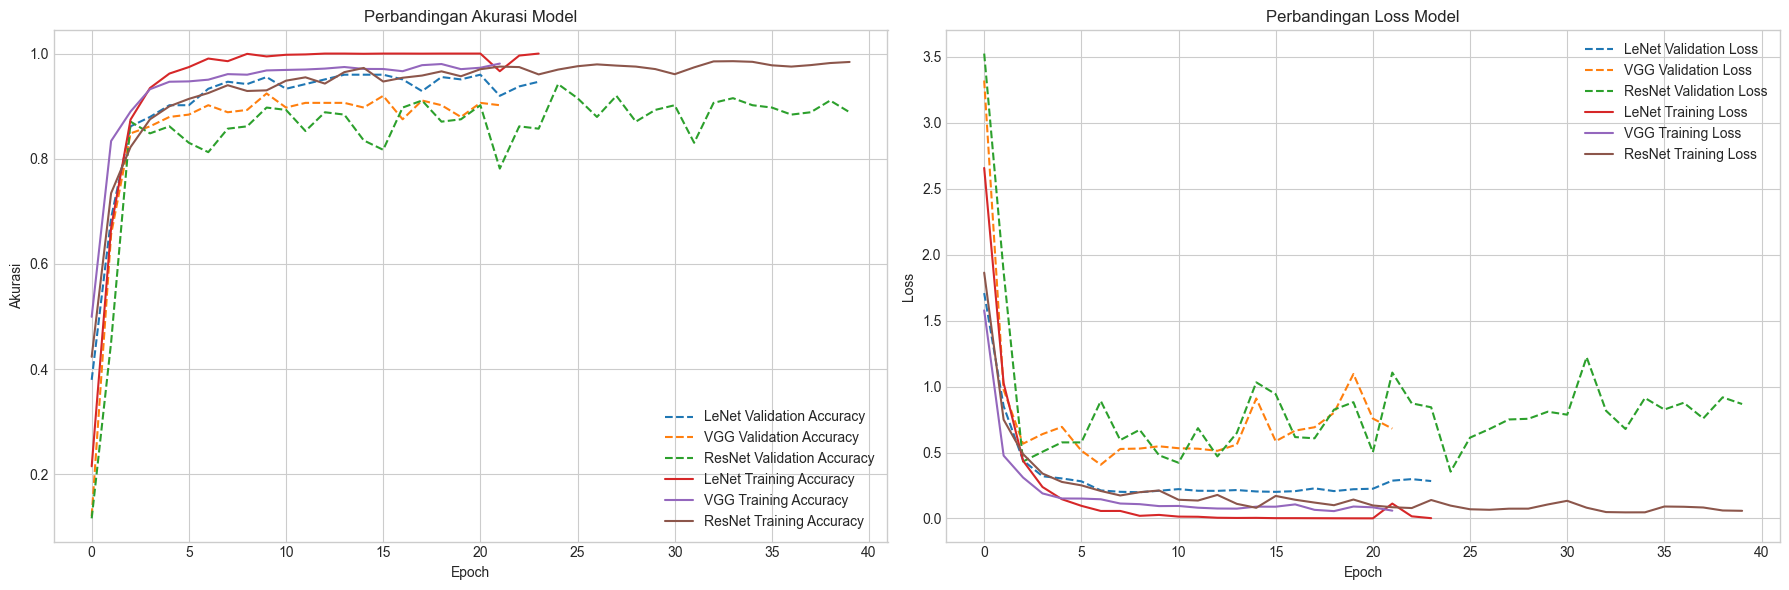

In [8]:
import matplotlib.pyplot as plt

# 1. Evaluasi Performa pada Data Uji
print("\n\n--- Hasil Evaluasi pada Data Uji (Tak Tersentuh) ---")
loss_lenet, acc_lenet = lenet_model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
loss_vgg, acc_vgg = vgg_model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
loss_resnet, acc_resnet = resnet_model.evaluate(X_test_reshaped, y_test_cat, verbose=0)

print(f"LeNet-5      -> Akurasi: {acc_lenet*100:.2f}%, Loss: {loss_lenet:.4f}")
print(f"VGG-like     -> Akurasi: {acc_vgg*100:.2f}%, Loss: {loss_vgg:.4f}")
print(f"ResNet-like  -> Akurasi: {acc_resnet*100:.2f}%, Loss: {loss_resnet:.4f}")

# 2. Perbandingan Konfigurasi Model (Jumlah Parameter)
print("\n--- Perbandingan Konfigurasi (Kompleksitas Model) ---")
print(f"LeNet-5      -> Total Parameter: {lenet_model.count_params()}")
print(f"VGG-like     -> Total Parameter: {vgg_model.count_params()}")
print(f"ResNet-like  -> Total Parameter: {resnet_model.count_params()}")

# 3. Visualisasi Kurva Pembelajaran
print("\n--- Menampilkan Grafik Perbandingan Kurva Pembelajaran ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 6))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(lenet_history.history['val_accuracy'], label='LeNet Validation Accuracy', linestyle='--')
plt.plot(vgg_history.history['val_accuracy'], label='VGG Validation Accuracy', linestyle='--')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Validation Accuracy', linestyle='--')
plt.plot(lenet_history.history['accuracy'], label='LeNet Training Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG Training Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Training Accuracy')
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(lenet_history.history['val_loss'], label='LeNet Validation Loss', linestyle='--')
plt.plot(vgg_history.history['val_loss'], label='VGG Validation Loss', linestyle='--')
plt.plot(resnet_history.history['val_loss'], label='ResNet Validation Loss', linestyle='--')
plt.plot(lenet_history.history['loss'], label='LeNet Training Loss')
plt.plot(vgg_history.history['loss'], label='VGG Training Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Training Loss')
plt.title('Perbandingan Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Memuat model dan data uji...


Data berhasil dimuat.

Melakukan prediksi...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

           A       0.89      1.00      0.94         8
           B       1.00      1.00      1.00         8
           C       1.00      0.88      0.93         8
           D       0.88      0.88      0.88         8
           E       0.86      0.67      0.75         9
           F       0.78      0.78      0.78         9
           G       1.00      1.00      1.00         9
           H       1.00      0.89      0.94         9
           I       0.73      1.00      0.84         8
           J       1.00      0.78      0.88         9
           K       0.78      0.88      0.82         8
           L       0.75      0.82      0.78        11
           M       0.82      0.90      0.86        10
           N       1.00      0.89      0.94         9
           O       1.00      1.00      1.00         7
           P       1.0

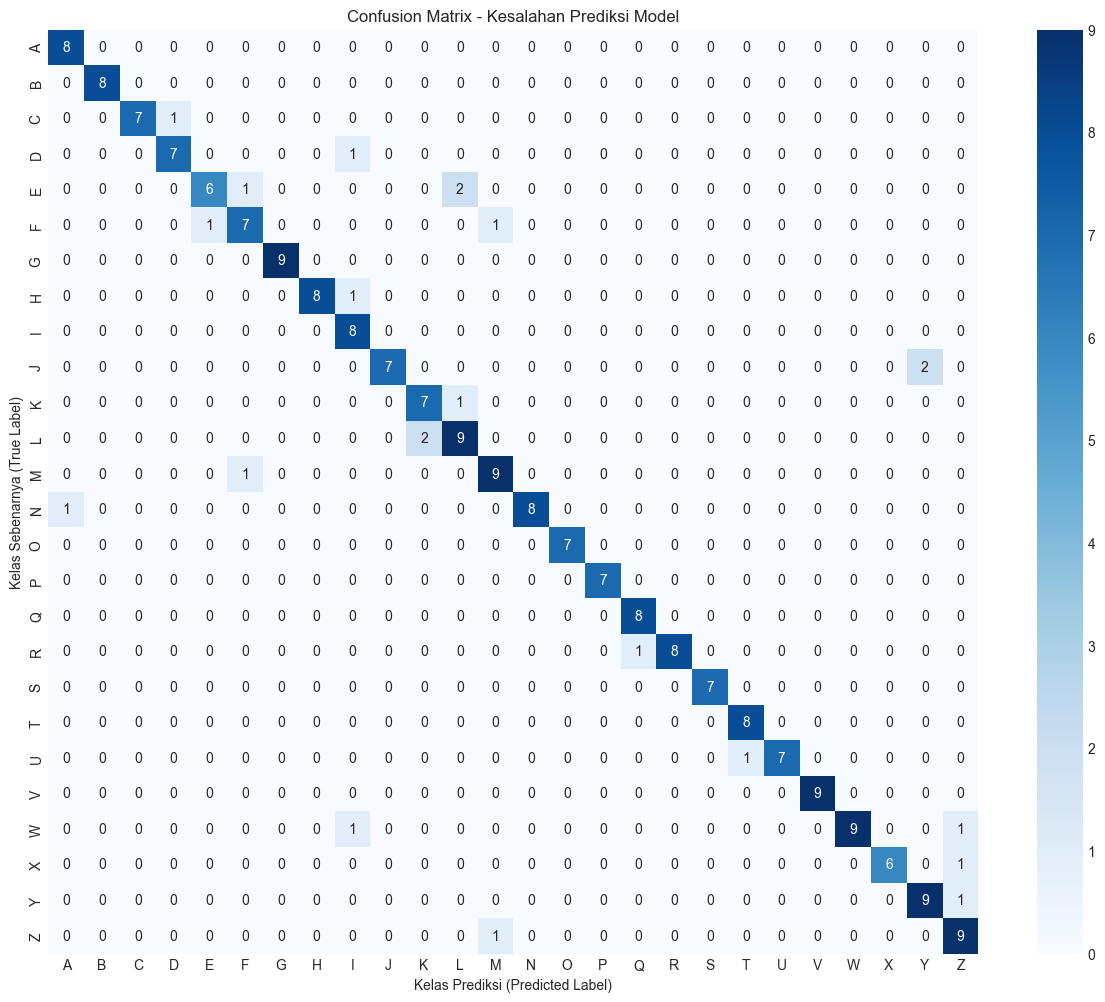


--- Analisis Kesalahan Spesifik ---
1. Model salah memprediksi:
   > Huruf Sebenarnya: 'N'
   > Diprediksi sebagai: 'A' (Keyakinan: 79.61%)
--------------------
2. Model salah memprediksi:
   > Huruf Sebenarnya: 'E'
   > Diprediksi sebagai: 'F' (Keyakinan: 99.99%)
--------------------
3. Model salah memprediksi:
   > Huruf Sebenarnya: 'Z'
   > Diprediksi sebagai: 'M' (Keyakinan: 56.13%)
--------------------
4. Model salah memprediksi:
   > Huruf Sebenarnya: 'X'
   > Diprediksi sebagai: 'Z' (Keyakinan: 86.03%)
--------------------
5. Model salah memprediksi:
   > Huruf Sebenarnya: 'Y'
   > Diprediksi sebagai: 'Z' (Keyakinan: 38.32%)
--------------------
6. Model salah memprediksi:
   > Huruf Sebenarnya: 'F'
   > Diprediksi sebagai: 'M' (Keyakinan: 64.15%)
--------------------
7. Model salah memprediksi:
   > Huruf Sebenarnya: 'W'
   > Diprediksi sebagai: 'I' (Keyakinan: 86.95%)
--------------------
8. Model salah memprediksi:
   > Huruf Sebenarnya: 'C'
   > Diprediksi sebagai: 'D' (Key

In [9]:
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. MEMUAT MODEL DAN DATA UJI ---
print("Memuat model dan data uji...")

# Muat model terbaik Anda
model = load_model('semaphore_vgg_like.h5')

# Muat data uji yang "murni" (landmark dan label asli sebelum one-hot encoding)
# NOTE: Pastikan Anda memiliki file X_test.npy dan y_test.npy yang disimpan
# dari proses pembagian data sebelumnya. Jika belum ada, Anda perlu
# menjalankan ulang skrip pembagian data dan menyimpannya.

# Contoh cara menyimpan data uji:
# np.save('X_test.npy', X_test) 
# np.save('y_test.npy', y_test)

try:
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')
except FileNotFoundError:
    print("\nPERINGATAN: File X_test.npy atau y_test.npy tidak ditemukan.")
    print("Anda perlu menyimpan data uji dari skrip training terlebih dahulu.")
    # Jika file tidak ada, kita hentikan eksekusi
    exit()

# Reshape data uji untuk prediksi
X_test_reshaped = np.expand_dims(X_test, axis=2)

print("Data berhasil dimuat.")

# --- 2. MELAKUKAN PREDIKSI PADA DATA UJI ---
print("\nMelakukan prediksi...")
predictions = model.predict(X_test_reshaped)
# Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap prediksi
predicted_classes = np.argmax(predictions, axis=1)

# `y_test` sudah dalam format numerik (0-25), jadi kita bisa langsung gunakan
true_classes = y_test

# Membuat daftar label huruf dari A-Z
labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# --- 3. MENAMPILKAN LAPORAN KLASIFIKASI & CONFUSION MATRIX ---

# Laporan Klasifikasi (Precision, Recall, F1-Score)
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(true_classes, predicted_classes, target_names=labels))

# Confusion Matrix untuk visualisasi kesalahan
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Kesalahan Prediksi Model')
plt.ylabel('Kelas Sebenarnya (True Label)')
plt.xlabel('Kelas Prediksi (Predicted Label)')
plt.show()


# --- 4. MENCARI DAN MENAMPILKAN KESALAHAN SPESIFIK ---
print("\n--- Analisis Kesalahan Spesifik ---")
error_count = 0
for i in range(len(true_classes)):
    if predicted_classes[i] != true_classes[i]:
        error_count += 1
        true_label = labels[true_classes[i]]
        predicted_label = labels[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        print(f"{error_count}. Model salah memprediksi:")
        print(f"   > Huruf Sebenarnya: '{true_label}'")
        print(f"   > Diprediksi sebagai: '{predicted_label}' (Keyakinan: {confidence:.2f}%)")
        print("-" * 20)

if error_count == 0:
    print("Selamat! Tidak ditemukan kesalahan pada data uji.")

In [10]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

# Muat model yang sudah dilatih
model = load_model('semaphore_vgg_like.h5') # Ganti dengan nama model terbaik Anda

# Label huruf
LABELS = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Inisialisasi MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Konversi warna dan proses dengan MediaPipe
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Ekstraksi landmark jika terdeteksi
    if results.pose_landmarks:
        # Gambar landmark pada frame
        mp.solutions.drawing_utils.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
        )
        
        try:
            # Siapkan data untuk prediksi
            landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]).flatten()
            landmarks = np.expand_dims(landmarks, axis=0) # -> (1, 132)
            landmarks = np.expand_dims(landmarks, axis=2) # -> (1, 132, 1)
            
            # Lakukan prediksi
            prediction = model.predict(landmarks)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            
            # Tampilkan hasil
            text = f"Huruf: {LABELS[predicted_class]} ({confidence*100:.2f}%)"
            cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
        except Exception as e:
            print(f"Error saat prediksi: {e}")

    cv2.imshow('Deteksi Semaphore Pramuka', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
pose.close()

c:\Users\Rezky\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 